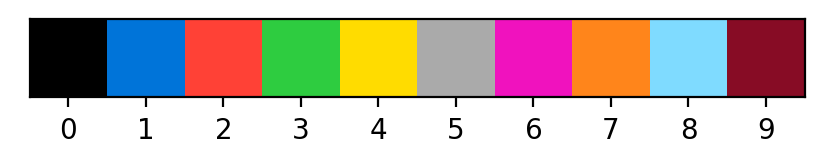

100%|██████████| 5/5 [00:58<00:00, 11.76s/it]


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# Any results you write to the current directory are saved as output.

import numpy as np
import pandas as pd
import os
import json
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
from lightgbm import LGBMClassifier
from collections import defaultdict
from multiprocessing import Process, Queue, current_process, Manager
import pdb
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
import random

data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'
training_tasks = sorted(os.listdir(training_path))
eval_tasks = sorted(os.listdir(evaluation_path))

cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

def Defensive_Copy(A): 
    n = len(A)
    k = len(A[0])
    L = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            L[i,j] = 0 + A[i][j]
    return L.tolist()

def Create(task, task_id = 0):
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][i]['input']) for i in range(n)]
    Output = [Defensive_Copy(task['train'][i]['output']) for i in range(n)]
    Input.append(Defensive_Copy(task['test'][task_id]['input']))
    return Input, Output

def Recolor(task):
    Input = task[0]
    Output = task[1]
    Test_Picture = Input[-1]
    Input = Input[:-1]
    N = len(Input)
    
    for x, y in zip(Input, Output):
        if len(x) != len(y) or len(x[0]) != len(y[0]):
            return -1
        
    Best_Dict = -1
    Best_Q1 = -1
    Best_Q2 = -1
    Best_v = -1
    # v ranges from 0 to 3. This gives an extra flexibility of measuring distance from any of the 4 corners
    Pairs = []
    for t in range(15):
        for Q1 in range(1,8):
            for Q2 in range(1,8):
                if Q1+Q2 == t:
                    Pairs.append((Q1,Q2))
                    
    for Q1, Q2 in Pairs:
        for v in range(4):
    
  
            if Best_Dict != -1:
                continue
            possible = True
            Dict = {}
                      
            for x, y in zip(Input, Output):
                n = len(x)
                k = len(x[0])
                for i in range(n):
                    for j in range(k):
                        if v == 0 or v ==2:
                            p1 = i%Q1
                        else:
                            p1 = (n-1-i)%Q1
                        if v == 0 or v ==3:
                            p2 = j%Q2
                        else :
                            p2 = (k-1-j)%Q2
                        color1 = x[i][j]
                        color2 = y[i][j]
                        if color1 != color2:
                            rule = (p1, p2, color1)
                            if rule not in Dict:
                                Dict[rule] = color2
                            elif Dict[rule] != color2:
                                possible = False
            if possible:
                
                # Let's see if we actually solve the problem
                for x, y in zip(Input, Output):
                    n = len(x)
                    k = len(x[0])
                    for i in range(n):
                        for j in range(k):
                            if v == 0 or v ==2:
                                p1 = i%Q1
                            else:
                                p1 = (n-1-i)%Q1
                            if v == 0 or v ==3:
                                p2 = j%Q2
                            else :
                                p2 = (k-1-j)%Q2
                           
                            color1 = x[i][j]
                            rule = (p1,p2,color1)
                            
                            if rule in Dict:
                                color2 = 0 + Dict[rule]
                            else:
                                color2 = 0 + y[i][j]
                            if color2 != y[i][j]:
                                possible = False 
                if possible:
                    Best_Dict = Dict
                    Best_Q1 = Q1
                    Best_Q2 = Q2
                    Best_v = v
                
                
    if Best_Dict == -1:
        return -1 #meaning that we didn't find a rule that works for the traning cases
    
    #Otherwise there is a rule: so let's use it:
    n = len(Test_Picture)
    k = len(Test_Picture[0])
    
    answer = np.zeros((n,k), dtype = int)
   
    for i in range(n):
        for j in range(k):
            if Best_v == 0 or Best_v ==2:
                p1 = i%Best_Q1
            else:
                p1 = (n-1-i)%Best_Q1
            if Best_v == 0 or Best_v ==3:
                p2 = j%Best_Q2
            else :
                p2 = (k-1-j)%Best_Q2
           
            color1 = Test_Picture[i][j]
            rule = (p1, p2, color1)
            if (p1, p2, color1) in Best_Dict:
                answer[i][j] = 0 + Best_Dict[rule]
            else:
                answer[i][j] = 0 + color1
                                            
    return answer.tolist()

def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    
def plot_train_samples(task, train_len=2):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 2 * train_len, figsize=(7, 7))
    for i in range(train_len):
        axs[i * 2].imshow(task['train'][i]['input'], cmap=cmap, norm=norm)
        axs[i * 2].axis('off')
        axs[i * 2].set_title('Train Input')
        axs[i * 2 + 1].imshow(task['train'][i]['output'], cmap=cmap, norm=norm)
        axs[i * 2 + 1].axis('off')
        axs[i * 2 + 1].set_title('Train Output')
    plt.tight_layout()
    plt.show()
    
def plot_test(test_prediction, task_name, task_input):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 2, figsize=(7, 7))
    axs[0].imshow(task_input, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title(f'Test Input {task_name}')
    axs[1].imshow(test_prediction, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title(f'Test Prediction {task_name}')
    plt.tight_layout()
    plt.show()

def unchanged_shape(task):
    unchanged=True
    for sample in task['train']:
        array_train = np.array(sample['input'])
        array_train[array_train > 0] = 1
        array_test = np.array(sample['output'])
        array_test[array_test > 0] = 1
        
        unchanged &= np.array_equal(array_train, array_test)

    return unchanged

def plot_picture(x):
    plt.imshow(np.array(x), cmap = cmap, norm = norm)
    plt.show()

def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def get_moore_neighbours(color, cur_row, cur_col, nrows, ncols):
    if cur_row + 1 < nrows: 
        bottom = color[cur_row + 1][cur_col]
    else: 
        bottom = -1
    
    if cur_row - 1 >= 0:
        top = color[cur_row - 1][cur_col]
    else: 
        top = -1
        
    if cur_col - 1 >= 0: 
        left = color[cur_row][cur_col - 1]
    else: 
        left = -1
        
    if cur_col + 1 < ncols: 
        right = color[cur_row][cur_col + 1]
    else: 
        right = -1
        
    return top, bottom, left, right

def get_tl_tr(color, cur_row, cur_col, nrows, ncols):    
    if cur_row - 1 >= 0 and cur_col - 1 >= 0:
        top_left = color[cur_row - 1][cur_col - 1]
    else:
        top_left = -1
        
    if cur_row - 1 >= 0 and cur_col + 1 < ncols:
        top_right = color[cur_row - 1][cur_col + 1]
    else:
        top_right = -1
        
    if cur_row + 1 < nrows and cur_col + 1 < ncols:
        bottom_right = color[cur_row + 1][cur_col + 1]
    else:
        bottom_right = -1
        
    if cur_row + 1 < nrows and cur_col - 1 >= 0:
        bottom_left = color[cur_row + 1][cur_col - 1]
    else:
        bottom_left = -1
        
    return top_left, top_right, bottom_left, bottom_right

def inside_borders(x, y, dx, dy, rows, columns):
    return x + dx < rows and x + dx >= 0 and y + dy < columns and y + dy >= 0

def bfs(row, col, visited, label, src_color_matrix, enable_diagonal):
    color = src_color_matrix[row][col]
    q = [(row, col)]
    nrows, ncols = visited.shape
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    if enable_diagonal:
        directions += [(1, 1), (1, -1), (-1, 1), (-1, -1)]
    size = 1
    while len(q) != 0:
        cur_row, cur_col = q.pop(0)
        visited[cur_row][cur_col] = label
        for dx, dy in directions:
            if inside_borders(cur_row, cur_col, dx, dy, src_color_matrix.shape[0], src_color_matrix.shape[1]):
                if not visited[cur_row + dx][cur_col + dy] and src_color_matrix[cur_row + dx][cur_col + dy] == color:
                    q.append((cur_row + dx, cur_col + dy))
                    visited[cur_row + dx][cur_col + dy] = label
                    size += 1
    
    return size

def get_connected_components_info(src_color_matrix, enable_diagonal):
    connect_size = defaultdict(int)
    rows, cols = src_color_matrix.shape
    info_matrix = np.empty(src_color_matrix.shape, dtype=object)
    visited = np.zeros_like(src_color_matrix)
    label = 1
    for i in range(rows):
        for j in range(cols):
            if not visited[i][j]:
                connect_size[label] = bfs(i, j, visited, label, src_color_matrix, enable_diagonal)
                label += 1
            info_matrix[i][j] = (connect_size[visited[i][j]], visited[i][j])
    
    return info_matrix

def get_array_counters(array, row, unique_str, non_uniqe_str, init_color, is_max_indent):
    values, counts = np.unique(array, return_counts=True)
    val_count = dict(zip(values, counts))
    if is_max_indent:
        for i in range(0, 10):
            if i not in val_count.keys():
                row[non_uniqe_str + " color:" + str(i)] = 0
            else:
                row[non_uniqe_str + " color:" + str(i)] = val_count[i]
            
    row[unique_str] = values.reshape(-1).shape[0]
    
    return row

def generate_box_features(row, src_color_matrix, indents):
    rows_amount, columns_amount = src_color_matrix.shape[0], src_color_matrix.shape[1]
    init_col, init_row = int(row['col']), int(row['row'])
    for indent in indents:
        start_col, start_row = max(init_col - indent, 0), max(init_row - indent, 0)
        end_col, end_row = min(init_col + indent, columns_amount - 1), min(init_row + indent, rows_amount - 1)
        row = get_array_counters(src_color_matrix[start_row : end_row + 1, start_col : end_col + 1], row,
                           "unique_colors in square indent " + str(indent),
                           "non-unique_colors in square indent " + str(indent), 
                           src_color_matrix[init_row][init_col], True)            
    return row

def generate_simple_neighbours_features(row, src_color_matrix, src_comp_info, src_comp_diag_info, comp_label_is_cycle, comp_label_size_ordered):
    rows_amount, columns_amount = src_color_matrix.shape[0], src_color_matrix.shape[1]
    cur_col, cur_row = int(row['col']), int(row['row'])
    cur_color = src_color_matrix[cur_row][cur_col]
    row['top_color'], row['bottom_color'], row['left_color'], row['right_color'] = get_moore_neighbours(src_color_matrix, 
                                                                      cur_row, cur_col, 
                                                                      rows_amount, columns_amount)
    row['top_left_color'], row['top_right_color'], row['bottom_left_color'], row['bottom_right_color'] = get_tl_tr(src_color_matrix, cur_row, cur_col,
                                                              rows_amount, columns_amount)

    row['symmetry_position'] = cur_row + cur_col
    
#     row["unique_rows"] = len(np.unique(src_color_matrix[cur_row,:]))
#     row["unique_cols"] = len(np.unique(src_color_matrix[:,cur_col]))
#     row["unique"] = len(np.unique(src_color_matrix[cur_row-5:cur_row+5,
#                                                  cur_col-5:cur_col+5]))
    row['until_border_col'] = columns_amount - 1 - cur_col
    row['until_border_row'] = rows_amount - 1 - cur_row
    
    row['row_num%2'] = cur_row % 2
    row['row_num%3'] = cur_row % 3
    row['row_num%4'] = cur_row % 4
    row['row_num%5'] = cur_row % 5
    
    row['col_num%2'] = cur_col % 2
    row['col_num%3'] = cur_col % 3
    row['col_num%4'] = cur_col % 4
    row['col_num%5'] = cur_col % 5
            
    row["comp_size_diag"], row["comp_num_diag"] = src_comp_diag_info[cur_row][cur_col]
    row["comp_size"], row["comp_num"] = src_comp_info[cur_row][cur_col]
    
    row["is_in_cycle"] = comp_label_is_cycle[row["comp_num"]]
    
    row["sorted_place_by_comp_size"] = comp_label_size_ordered[row["comp_num"]]
    
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    for direction in directions:
        if inside_borders(cur_row, cur_col, direction[0], direction[1], src_color_matrix.shape[0], src_color_matrix.shape[1]):
            row["comp_num at dir " + str(direction)] = src_comp_info[cur_row + direction[0]][cur_col + direction[1]][1]
        else:
            row["comp_num at dir " + str(direction)] = -1
    
    if cur_col < rows_amount and cur_row < columns_amount:
        row["symmetry_diag_pos"] = int(src_color_matrix[cur_col][cur_row] == src_color_matrix[cur_row][cur_col])
    else:
        row["symmetry_diag_pos"] = 0
        
    if rows_amount - 1 - cur_col >= 0 and columns_amount - 1 - cur_row >= 0 and rows_amount - 1 - cur_col < columns_amount and columns_amount - 1 - cur_row < rows_amount:
        row["symmetry_diag_neg"] = int(src_color_matrix[columns_amount - 1 - cur_row][rows_amount - 1 - cur_col] == src_color_matrix[cur_row][cur_col])
    else:
        row["symmetry_diag_neg"] = 0
        
    row["symmetry_vertical"] = int(src_color_matrix[cur_row][columns_amount - 1 - cur_col] == src_color_matrix[cur_row][cur_col])
    row["symmetry_horizontal"] = int(src_color_matrix[rows_amount - 1 - cur_row][cur_col] == src_color_matrix[cur_row][cur_col])
    
    row["rows_amount"] = rows_amount
    row["columns_amount"] = columns_amount
    
    return row
            
def generate_line_features(row, src_color_matrix, indents):
    rows_amount, columns_amount = src_color_matrix.shape[0], src_color_matrix.shape[1]
    am_colors_left, am_colors_right = defaultdict(int), defaultdict(int)
    am_colors_up, am_colors_down = defaultdict(int), defaultdict(int)
    cur_col, cur_row = int(row['col']), int(row['row'])
    for indent in indents:
        start_col, start_row = max(cur_col - indent, 0), max(cur_row - indent, 0)
        get_array_counters(src_color_matrix[cur_row + 1:, cur_col], row,
                           "unique_colors down indent " + str(indent),
                           "non-unique_colors down indent " + str(indent),
                           src_color_matrix[cur_row][cur_col], True)
        get_array_counters(src_color_matrix[start_row : cur_row, cur_col], row,
                           "unique_colors up indent " + str(indent),
                           "non-unique_colors up indent " + str(indent),
                           src_color_matrix[cur_row][cur_col], True)
        get_array_counters(src_color_matrix[cur_row, start_col : cur_col], row,
                           "unique_colors left indent " + str(indent),
                           "non-unique_colors left indent " + str(indent),
                           src_color_matrix[cur_row][cur_col], True)
        get_array_counters(src_color_matrix[cur_row, cur_col + 1:], row,
                           "unique_colors right indent " + str(indent),
                           "non-unique_colors right indent " + str(indent),
                           src_color_matrix[cur_row][cur_col], True)
        return row

def compute_one_sample(input_color, target_color, comp_info, comp_info_diag, comp_label_is_cycle, comp_label_size_ordered, mode, i, j, k, indents, return_dict):
    features = pd.DataFrame()
    input_color_processed = input_color
    output_color_processed = target_color
    comp_info_processed = comp_info
    comp_info_diag_processed = comp_info_diag
    if mode == 'train':
        # perform rotating
#         input_color_processed = np.rot90(input_color_processed, i)
#         output_color_processed = np.rot90(output_color_processed, i)
#         comp_info_processed = np.rot90(comp_info_processed, i)
#         comp_info_diag_processed = np.rot90(comp_info_diag_processed, i)
        # perform horizontal flipping
        if j == 1:
            input_color_processed = np.flip(input_color_processed, 0)
            output_color_processed = np.flip(output_color_processed, 0)
            comp_info_processed = np.flip(comp_info_processed, 0)
            comp_info_diag_processed = np.flip(comp_info_diag_processed, 0)
        # perform vertical flipping
        if k == 1:
            input_color_processed = np.flip(input_color_processed, 1)
            output_color_processed = np.flip(output_color_processed, 1)
            comp_info_processed = np.flip(comp_info_processed, 1)
            comp_info_diag_processed = np.flip(comp_info_diag_processed, 1)

    nrows, ncols = input_color_processed.shape[0], input_color_processed.shape[1]
    for row_num in range(nrows):
        for col_num in range(ncols):
            features = features.append(pd.DataFrame([[row_num, col_num, input_color_processed[row_num][col_num], 
                                                      output_color_processed[row_num][col_num]]], 
                                                      columns=['row', 'col', 'input_color', 'target_color']))

    features = features.reset_index(drop=True)
    features = features.apply(generate_simple_neighbours_features, args=(input_color_processed, comp_info_processed, comp_info_diag_processed, comp_label_is_cycle, comp_label_size_ordered), axis=1)
    features = features.apply(generate_line_features, args=(input_color_processed, indents), axis=1)
    features = features.apply(generate_box_features, args=(input_color_processed, indents), axis=1)
        
    return_dict[(i, j, k)] = features
    
    return features

def dfs(parent, cur, src_matrix, visited_matrix, comp_label_is_cycle):
    cur_row, cur_col = cur[0], cur[1]
    parent_row, parent_col = parent[0], parent[1]
    visited_matrix[cur_row, cur_col] = 1
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for dx, dy in directions:
        if inside_borders(cur_row, cur_col, dx, dy, src_matrix.shape[0], src_matrix.shape[1]):
            new_x = cur_row + dx
            new_y = cur_col + dy
            if parent_row != -1 and src_matrix[new_x][new_y] != src_matrix[parent_row][parent_col]:
                continue
            if new_x == parent_row and new_y == parent_col:
                continue
            if visited_matrix[new_x][new_y]:
                comp_label_is_cycle[src_matrix[new_x][new_y]] = 1
                continue
            dfs((cur_row, cur_col), (new_x, new_y), src_matrix, visited_matrix, comp_label_is_cycle)
            
def detect_cycles(src_matrix):
    visited_matrix = np.zeros_like(src_matrix)
    comp_label_is_cycle = defaultdict(int)
    for i in range(src_matrix.shape[0]):
        for j in range(src_matrix.shape[1]):
            if not visited_matrix[i][j]:
                dfs((-1, -1), (i, j), src_matrix, visited_matrix, comp_label_is_cycle)
    
    return comp_label_is_cycle
            
def compute_features(input_color, target_color, all_features, max_indent, mode):
    manager = Manager()
    return_dict = manager.dict()
    processes = []
    comp_info = get_connected_components_info(input_color, False) # Connected components classic
    comp_info_diag = get_connected_components_info(input_color, True) # Connected components with diagonal connections
    
    comp_info_cycle = np.zeros_like(comp_info)
    for i in range(comp_info.shape[0]):
        for j in range(comp_info.shape[1]):
            comp_info_cycle[i][j] = comp_info[i][j][1]
            
    comp_label_is_cycle = detect_cycles(comp_info_cycle)
    
    comp_label_size = defaultdict(int)
    for i in range(comp_info.shape[0]):
        for j in range(comp_info.shape[1]):
            comp_label_size[comp_info[i][j][1]] = comp_info[i][j][0]
            
    comp_label_size = sorted(comp_label_size.items(), key=lambda x: x[1])
    comp_label_size_ordered = defaultdict(int)
    index = 0
    prev = -1
    for key, value in comp_label_size:
        comp_label_size_ordered[key] = index
        if prev != value:
            index += 1
        prev = value
    
#     for i in range(4):
#         if input_color.shape[0] * input_color.shape[1] <= 100 and mode != 'test':
#             for j in range(2):
#                 for k in range(2):
#                     p = Process(target=compute_one_sample, args=(input_color, target_color, comp_info, comp_info_diag, comp_label_is_cycle, comp_label_size_ordered, mode, i, j, k, max_indent, return_dict))
#                     processes.append(p)
#                     p.start()
#         else:
#             p = Process(target=compute_one_sample, args=(input_color, target_color, comp_info, comp_info_diag, comp_label_is_cycle, comp_label_size_ordered, mode, i, 0, 0, max_indent, return_dict))
#             processes.append(p)
#             p.start()

#         if mode == 'test':
#             break
    p = Process(target=compute_one_sample, args=(input_color, target_color, comp_info, comp_info_diag, comp_label_is_cycle, comp_label_size_ordered, mode, 0, 0, 0, max_indent, return_dict))
    processes.append(p)
    p.start()   
    for p in processes:
        p.join()
        
    for key, value in return_dict.items():
        all_features = pd.concat([all_features, value])
        
    all_features = all_features.reset_index(drop=True)
        
    return all_features

def features(task, max_indent, mode, test_indx=0):
    num_train_pairs = len(task[mode])
    features = pd.DataFrame()
    
    if mode == 'train':
        for train_indx in tqdm(range(num_train_pairs)):
            nrows, ncols = len(task[mode][train_indx]['input']), len(task[mode][train_indx]['input'][0])
            input_color = np.array(task[mode][train_indx]['input'])
            target_color = np.array(task[mode][train_indx]['output'])
            target_rows, target_cols = len(task[mode][train_indx]['output']), len(task[mode][train_indx]['output'][0])
            
            if (target_rows != nrows) or (target_cols != ncols):
                return None, None, 0

            features = compute_features(input_color, target_color, features, max_indent, 'train')
    else:
        nrows, ncols = len(task[mode][test_indx]['input']), len(task[mode][test_indx]['input'][0])
        input_color = np.array(task[mode][test_indx]['input'])
        target_color = input_color
        
        features = compute_features(input_color, target_color, features, max_indent, 'test')
        
    if features.target_color.unique().shape[0] <= 1 and mode == 'train':
        return None, None, 0
    
    features = features.reset_index(drop=True)
    target = features["target_color"]
    
    del features["target_color"]
    features = features.reindex(sorted(features.columns), axis=1)
    
    return features, target, 1

def match_figure_types(src_color_matrix):
    return

def apply_strategy(src, strategy, augment_functions):
    for i in range(len(strategy)):
        src = augment_functions[i](src, strategy[i])
    return src

def do_nothing(src, *args):
    return src

def try_to_match_simple_strategy(src, dst, augment_functions, strategy=[]):
    if strategy is None:
        return None
    
    row_replica_factor = dst.shape[0] / src.shape[0]
    col_replica_factor = dst.shape[1] / src.shape[1]
    
    if not src.shape == dst.shape:
        return None
    
    if strategy == []:
        strategy = [0, 0, 0]
        for rot_times in range(4):
            for flip in range(2):
                for do_unflip in range(2):
                    strategy[0] = rot_times
                    strategy[1] = flip
                    strategy[2] = flip
                    if do_unflip == 0:
                        augment_functions[2] = do_nothing
                    else:
                        augment_functions[2] = np.flip
                    result = apply_strategy(src.copy(), strategy, augment_functions)
                    if np.array_equal(dst, result):
                        return strategy
        return None
    else:
        result = apply_strategy(src.copy(), strategy, augment_functions)
    
    if np.array_equal(dst, result):
        return strategy
    
    return None

def fill_preds(preds, nrows, ncols, sample_sub, task_id, task_num):
    preds = preds.astype(int).reshape(nrows, ncols).tolist()
    preds = flattener(preds)
    sample_sub.loc[f'{task_id[:-5]}_{task_num}', 'output'] += preds
    
input_path = test_path
all_task_ids = sorted(os.listdir(input_path))
# random.shuffle(all_task_ids)

sample_sub = pd.read_csv(data_path / 'sample_submission.csv')
example_grid = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
all_ids_init = sample_sub['output_id'].values
sample_sub = sample_sub.set_index('output_id')

indents = [5]

am_correct = 0
attempts = 0
attempts_total = 0

for task_id in all_task_ids:
    
    attempts_total += 1
    task_file = str(input_path / task_id)
    
    with open(task_file, 'r') as f:
        task = json.load(f)
        
    need_only_recolor = unchanged_shape(task)
    need_only_recolor = False
    
    train_X, train_Y, same_size = features(task, indents, 'train')
   
    if same_size == 1:
        if need_only_recolor:
            train_Y = train_Y[train_X['input_color'] > 0].reset_index(drop=True)
            train_X = train_X[train_X['input_color'] > 0].reset_index(drop=True)

        cols = list(train_X.columns)
        desired_cat_features = []
        cat_features = []
        for feature in desired_cat_features:
            cat_features.append(cols.index(feature))

        cb = CatBoostClassifier(iterations=2000, verbose=0, loss_function="MultiClass")
        cb.fit(train_X, train_Y)
        
#         feature_scores = {}
#         for score, name in zip(cb.feature_importances_, cb.feature_names_):
#             feature_scores[name] = score

#         feature_scores = sorted(feature_scores.items(), key=lambda kv: kv[1])
#         for pair in feature_scores:
#             if pair[1] > 1:
#                 print(pair)

        for task_num in range(len(task['test'])):
            input_color = np.array(task['test'][task_num]['input'])
            nrows, ncols = len(task['test'][task_num]['input']), len(task['test'][task_num]['input'][0])

            test_X, _, __ = features(task, indents, 'test', task_num)
            if need_only_recolor:
                to_prediсt_X = test_X[test_X['input_color'] > 0]
                preds = np.zeros((nrows * ncols, 1), dtype=int)
                preds[test_X['input_color'] > 0] = cb.predict(to_prediсt_X)
                preds = preds.reshape(nrows, ncols)
            else:
                preds = cb.predict(test_X).reshape(nrows, ncols)
                
            preds = preds.astype(int).tolist()
            
            sample_sub.loc[f'{task_id[:-5]}_{task_num}', 'output'] = flattener(preds)
            
#             if np.array_equal(preds.astype(int).reshape(nrows, ncols), task['test'][task_num]['output']):
#                 am_correct += 1
            
#             print("Correct solutions: ", am_correct, " of ", attempts_total)
#             preds = preds.astype(int).reshape(nrows, ncols).tolist()
#             plot_train_samples(task, 2)
#             plot_test(preds, task_id, task['test'][task_num]['input'])

Problems = all_ids_init
for i in range(len(Problems)):
    output_id = Problems[i]
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
   
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][j]['input']) for j in range(n)]
    Output = [Defensive_Copy(task['train'][j]['output']) for j in range(n)]
    Input.append(Defensive_Copy(task['test'][pair_id]['input']))
    
    solution = Recolor([Input, Output])
        
    if solution != -1:
        pred = flattener(solution)
        sample_sub.loc[f'{task_id}_{pair_id}', 'output'] = pred
            
sample_sub.to_csv("submission.csv")
#67a3c6ac.json 74dd1130.json 68b16354.json